![](https://images.unsplash.com/photo-1602084551218-a28205125639?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)

<div class = 'alert alert-block alert-info'
     style = 'background-color:#4c1c84;
              color:#eeebf1;
              border-width:5px;
              border-color:#4c1c84;
              font-family:Comic Sans MS;
              border-radius: 50px 50px'>
    <p style = 'font-size:24px'>Ensemble</p>
    <a href = "#Config"
       style = "color:#eeebf1;
                font-size:14px">1.Config</a><br>
    <a href = "#Settings"
       style = "color:#eeebf1;
                font-size:14px">2.Settings</a><br>
    <a href = "#Data-Load"
       style = "color:#eeebf1;
                font-size:14px">3.Data Load</a><br>
    <a href = "#Pytorch-Settings"
       style = "color:#eeebf1;
                font-size:14px">4.Pytorch Settings</a><br>
    <a href = "#Training"
       style = "color:#eeebf1;
                font-size:14px">5.Training</a><br>
</div>

<p style = 'font-size:24px;
            color:#4c1c84'>
    実施したこと
</p>
    <li style = "color:#4c1c84;
                font-size:14px">Ensemble</li>

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Config
</h1>
<br>

In [5]:
import sys
sys.path.append("../src/utils/iterative-stratification/")
sys.path.append("../src/utils/detoxify")
sys.path.append("../src/utils/coral-pytorch/")
sys.path.append("../src/utils/pyspellchecker")

In [6]:
!pip install --no-index --find-links ../src/utils/faiss/ faiss-gpu==1.6.3

Looking in links: ../src/utils/faiss/


In [7]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import copy
import math
import time
import random
import string
import psutil
import pathlib
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict
from box import Box
from typing import Optional
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW, AutoModelForSequenceClassification
from transformers import RobertaModel, RobertaForSequenceClassification
from transformers import RobertaTokenizer
from transformers import LukeTokenizer, LukeModel, LukeConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification, BertForMaskedLM
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import DebertaTokenizer, DebertaModel
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification
from transformers import AlbertTokenizer, AlbertModel

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning import LightningDataModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import rankdata
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from cuml.svm import SVR as cuml_SVR
from cuml.linear_model import Ridge as cuml_Ridge
import cudf
from detoxify import Detoxify
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from ast import literal_eval
from nltk.tokenize import TweetTokenizer
import spacy
from scipy.stats import sem
from copy import deepcopy
from spellchecker import SpellChecker
from typing import Text, Set, List

import faiss
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer as cuTfidfVectorizer
from cuml.neighbors import NearestNeighbors as cuNearestNeighbors
from cuml.decomposition.tsvd import TruncatedSVD as cuTruncatedSVD

2022-02-08 10:59:40.125979: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [8]:
import torch

config = {
    "exp_comment":"Psuedo Labeling",
    "seed": 42,
    "root": "/content/drive/MyDrive/kaggle/Jigsaw/raw",
    "n_fold": 10,
    "epoch": 5,
    "max_length": 256,
    "environment": "AWS",
    "project": "Jigsaw",
    "entity": "dataskywalker",
    "exp_name": "Ensemble",
    "margin": 0.5,
    "train_fold": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],

    "trainer": {
        "gpus": 1,
        "accumulate_grad_batches": 8,
        "progress_bar_refresh_rate": 1,
        "fast_dev_run": True,
        "num_sanity_val_steps": 0,
    },

    "train_loader": {
        "batch_size": 8,
        "shuffle": True,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": True,
    },

    "valid_loader": {
        "batch_size": 2,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "test_loader": {
        "batch_size": 2,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "backbone": {
        "name": "albert-base-v2",
        "output_dim": 1,
    },

    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-6,
        },
    },

    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },

    "loss": "nn.MarginRankingLoss",
}

config = Box(config)
# pprint(config)

In [9]:
# 個人的にAWSやKaggle環境やGoogle Colabを行ったり来たりしているのでまとめています
import os
import sys
from pathlib import Path

if config.environment == 'AWS':
    
    INPUT_DIR = Path('/mnt/work/data/kaggle/Jigsaw/')
    MODEL_DIR = Path(f'../models/{config.exp_name}/')
    OUTPUT_DIR = Path(f'../data/interim/{config.exp_name}/')
    UTIL_DIR = Path('/mnt/work/shimizu/kaggle/PetFinder/src/utils')
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print(f"Your environment is 'AWS'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}\nUTIL_DIR is {UTIL_DIR}")
    
    
elif config.environment == 'Kaggle':
    INPUT_DIR = Path('../input/*****')
    MODEL_DIR = Path('./')
    OUTPUT_DIR = Path('./')
    print(f"Your environment is 'Kaggle'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")

    
elif config.environment == 'Colab':
    INPUT_DIR = Path('/content/drive/MyDrive/kaggle/Jigsaw/raw')
    BASE_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/interim")

    MODEL_DIR = BASE_DIR / f'{config.exp_name}'
    OUTPUT_DIR = BASE_DIR / f'{config.exp_name}/'

    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_DIR):
        print('Please Mount your Google Drive.')
    else:
        print(f"Your environment is 'Colab'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")
        
else:
    print("Please choose 'AWS' or 'Kaggle' or 'Colab'.\nINPUT_DIR is not found.")

Your environment is 'AWS'.
INPUT_DIR is /mnt/work/data/kaggle/Jigsaw
MODEL_DIR is ../models/Ensemble
OUTPUT_DIR is ../data/interim/Ensemble
UTIL_DIR is /mnt/work/shimizu/kaggle/PetFinder/src/utils


In [10]:
# Seed固定
seed_everything(config.seed)

42

In [11]:
## 処理時間計測
@contextmanager
def timer(name:str, slack:bool=False):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield
    
    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)
    
    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec", file=sys.stderr)

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Data Load
</h1>
<br>

In [12]:
## Data Check
for dirnames, _, filenames in os.walk(INPUT_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv
/mnt/work/data/kaggle/Jigsaw/sample_submission.csv
/mnt/work/data/kaggle/Jigsaw/validation_data.csv


In [13]:
val_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/validation_data.csv")
test_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv")

display(val_df.head())
display(test_df.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


In [14]:
with timer("Count less text & more text"):
    less_df = val_df.groupby(["less_toxic"])["worker"].agg("count").reset_index()
    less_df.columns = ["text", "less_count"]

    more_df = val_df.groupby(["more_toxic"])["worker"].agg("count").reset_index()
    more_df.columns = ["text", "more_count"]
    
    text_df = pd.merge(
        less_df,
        more_df,
        on="text",
        how="outer"
    )

    text_df["less_count"] = text_df["less_count"].fillna(0)
    text_df["more_count"] = text_df["more_count"].fillna(0)
    
    text_df["target"] = text_df["more_count"]/(text_df["less_count"] + text_df["more_count"])
    
    display(text_df)

<< Count less text & more text >> Start


,text,less_count,more_count,target
0,\n\nThe comment directly above this one are fr...,1.0,2.0,0.666667
1,\n\nwhy should people have to read crap posted...,1.0,8.0,0.888889
2,\nGo F yourself you cottonheadednittymuggins.,1.0,2.0,0.666667
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",3.0,0.0,0.000000
4,\n\n koreans claim \n\ni see youve seen the ...,4.0,2.0,0.333333
...,...,...,...,...
14246,{{unblock|The reason I used sockpuppets was to...,0.0,3.0,1.000000
14247,{{unblock}} BECAUSE BAIL OUT IS THE BEST FUCK...,0.0,3.0,1.000000
14248,|Christopher Connor]]. I am off to my daily ma...,0.0,6.0,1.000000
14249,}} \n\nSomeone should address this fucking pro...,0.0,1.0,1.000000


<< Count less text & more text >> 1.7GB(-0.0GB):0.1sec


<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    OOF LOAD
</h1>
<br>

In [15]:
eval_df = val_df.copy()
rank_df = val_df.copy()

In [16]:
# exp_list = ["038_exp", "040_exp", "ohashi_040_exp"]
exp_list = [
#     "038_exp",
    "040_exp", 
    "041_exp", 
#     "047_exp",
#     "048_exp",
    "049_exp",
#     "051_exp",
    "052_exp",
#     "053_exp",

#     "035_exp_DeBERTa_Base__Jigsaw_Unbiased",
#     "035_exp_HATE_BERT__Jigsaw_classification",
#     "035_exp_HATE_BERT__Jigsaw_Unbiased",
#     "035_exp_Luke_Base__Wiki_Attack",
#     "035_exp_RoBERTa_Base__Jigsaw_Unbiased",
#     "035_exp_TFIDF_Ridge__Jigsaw_classification",
#     "035_exp_TFIDF_Ridge__Ruddit",
]

ohashi_list = ["ohashi_040_exp"]
thajime_list = ["thajime_0206_exp"]

exp_list += ohashi_list
exp_list += thajime_list

In [17]:
OOF_DF = pd.DataFrame()
OOF_DF["text"] = text_df["text"]

for exp in tqdm(exp_list, total=len(exp_list)):
    
    if ("ohashi" not in exp) and ("thajime" not in exp):
        
        oof = pd.read_pickle(f"../data/interim/{exp[:7]}/{exp}__text_df.pkl")
        oof.columns = ["text", f"{exp}__pred"]

        sc = StandardScaler()
        oof[f"{exp}__pred"] = sc.fit_transform(oof[f"{exp}__pred"].values.reshape(-1, 1))[:, 0] 
        
#         mm = MinMaxScaler()
#         oof[f"{exp}__pred"] = mm.fit_transform(oof[f"{exp}__pred"].values.reshape(-1, 1))[:, 0] 

        OOF_DF = pd.merge(
            OOF_DF,
            oof,
            on="text",
            how="left"
        )
        OOF_DF[f"{exp}__Rank"] = rankdata(OOF_DF[f"{exp}__pred"], method="ordinal")
        
    else:
        
        oof = pd.read_pickle(f"../data/interim/{exp}/{exp}__text_df.pkl")
        oof.columns = ["text", f"{exp}__pred"]
        
        sc = StandardScaler()
        oof[f"{exp}__pred"] = sc.fit_transform(oof[f"{exp}__pred"].values.reshape(-1, 1))[:, 0] 
        
#         mm = MinMaxScaler()
#         oof[f"{exp}__pred"] = mm.fit_transform(oof[f"{exp}__pred"].values.reshape(-1, 1))[:, 0] 

        OOF_DF = pd.merge(
            OOF_DF,
            oof,
            on="text",
            how="left"
        )
        OOF_DF[f"{exp}__Rank"] = rankdata(OOF_DF[f"{exp}__pred"], method="ordinal")
    
OOF_DF.head()

  0%|          | 0/6 [00:00<?, ?it/s]

,text,040_exp__pred,040_exp__Rank,041_exp__pred,041_exp__Rank,049_exp__pred,049_exp__Rank,052_exp__pred,052_exp__Rank,ohashi_040_exp__pred,ohashi_040_exp__Rank,thajime_0206_exp__pred,thajime_0206_exp__Rank
0,\n\nThe comment directly above this one are fr...,-0.354471,6288,-0.274179,6241,-0.049904,8325,-0.288842,6780,-0.494940,5277,-0.701147,2647
1,\n\nwhy should people have to read crap posted...,0.263590,9742,0.736330,11470,0.803563,11492,1.030180,12008,0.521151,10599,1.422190,12944
2,\nGo F yourself you cottonheadednittymuggins.,2.230693,13742,0.820761,11703,0.704832,11219,0.759504,11417,0.966582,11784,-0.370746,6939
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",-0.703533,3597,-0.484455,4867,-0.700648,3859,-0.726992,3614,0.052639,8856,-0.550089,4852
4,\n\n koreans claim \n\ni see youve seen the ...,-0.025503,8422,0.113479,8820,-0.187006,7543,-0.098659,8059,-0.255057,7167,-0.186648,8508


In [18]:
# plt.figure(figsize=(20, 5))

# plt.subplot(1, 2, 1)
# sns.scatterplot(OOF_DF[f"{exp_list[0]}__pred"], OOF_DF[f"{exp_list[1]}__pred"])
# plt.grid()
# plt.title("Score")

# plt.subplot(1, 2, 2)
# sns.scatterplot(OOF_DF[f"{exp_list[0]}__Rank__pred"], OOF_DF[f"{exp_list[-1]}__Rank__pred"])
# plt.grid()
# plt.title("Rank")

# plt.show()

In [19]:
## Mean Average
pred_cols = [col for col in OOF_DF.columns.tolist() if "__pred" in col]
rank_cols = [col for col in OOF_DF.columns.tolist() if "__Rank" in col]

print(len(pred_cols))
print(len(rank_cols))

OOF_DF["mean__pred"] = OOF_DF[pred_cols].mean(axis=1)
OOF_DF["mean__rank"] = OOF_DF[rank_cols].mean(axis=1)

display(OOF_DF.head())

6
6


,text,040_exp__pred,040_exp__Rank,041_exp__pred,041_exp__Rank,049_exp__pred,049_exp__Rank,052_exp__pred,052_exp__Rank,ohashi_040_exp__pred,ohashi_040_exp__Rank,thajime_0206_exp__pred,thajime_0206_exp__Rank,mean__pred,mean__rank
0,\n\nThe comment directly above this one are fr...,-0.354471,6288,-0.274179,6241,-0.049904,8325,-0.288842,6780,-0.494940,5277,-0.701147,2647,-0.360581,5926.333333
1,\n\nwhy should people have to read crap posted...,0.263590,9742,0.736330,11470,0.803563,11492,1.030180,12008,0.521151,10599,1.422190,12944,0.796167,11375.833333
2,\nGo F yourself you cottonheadednittymuggins.,2.230693,13742,0.820761,11703,0.704832,11219,0.759504,11417,0.966582,11784,-0.370746,6939,0.851937,11134.000000
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",-0.703533,3597,-0.484455,4867,-0.700648,3859,-0.726992,3614,0.052639,8856,-0.550089,4852,-0.518846,4940.833333
4,\n\n koreans claim \n\ni see youve seen the ...,-0.025503,8422,0.113479,8820,-0.187006,7543,-0.098659,8059,-0.255057,7167,-0.186648,8508,-0.106566,8086.500000


In [20]:
def calculate_acc_bce(eval_df:pd.DataFrame, OOF_DF:pd.DataFrame, exp_list:list):
    
    print("| Exp Name | Accuracy | BCE Loss |")
    print("|:--------:|:--------:|:--------:|")
    
    __eval_df = eval_df.copy()
    exp_list += ["mean"]
    
    for exp in exp_list:
        
        __eval_df = pd.merge(
            __eval_df,
            OOF_DF[["text", f"{exp}__pred"]],
            left_on = "less_toxic",
            right_on = "text",
            how = "left"
        )
        __eval_df = __eval_df.rename(columns={
            f"{exp}__pred": f"less__{exp}__pred"
        })
        __eval_df = __eval_df.drop("text", axis=1)

        __eval_df = pd.merge(
            __eval_df,
            OOF_DF[["text", f"{exp}__pred"]],
            left_on = "more_toxic",
            right_on = "text",
            how = "left"
        )
        __eval_df = __eval_df.rename(columns={
            f"{exp}__pred": f"more__{exp}__pred"
        })
        __eval_df = __eval_df.drop("text", axis=1)
        
        
        __eval_df[f"Diff__{exp}__pred"] = __eval_df[f"more__{exp}__pred"] - __eval_df[f"less__{exp}__pred"]
        tmp_acc = __eval_df[__eval_df[f"Diff__{exp}__pred"]>0][f"Diff__{exp}__pred"].count()/len(eval_df)

        logits = torch.tensor(__eval_df[f"Diff__{exp}__pred"].values, dtype=torch.float)
        target = torch.tensor(np.zeros(len(__eval_df))+1., dtype=torch.float)
        tmp_logloss = nn.BCEWithLogitsLoss()(logits, target).numpy()
        
        print(f"| {exp} | {tmp_acc:.5f} | {tmp_logloss:.5f} |")    

In [21]:
calculate_acc_bce(eval_df, OOF_DF, exp_list)

| Exp Name | Accuracy | BCE Loss |
|:--------:|:--------:|:--------:|
| 040_exp | 0.72898 | 0.53708 |
| 041_exp | 0.73502 | 0.52883 |
| 049_exp | 0.74409 | 0.52309 |
| 052_exp | 0.75203 | 0.51353 |
| ohashi_040_exp | 0.70403 | 0.56441 |
| thajime_0206_exp | 0.69214 | 0.58204 |
| mean | 0.74223 | 0.52613 |


In [281]:
OOF_DF
OOF_DF.to_pickle(OUTPUT_DIR/"oof_text_df.pkl")
OOF_DF.to_csv(OUTPUT_DIR/"oof_text_df.csv", index=False)

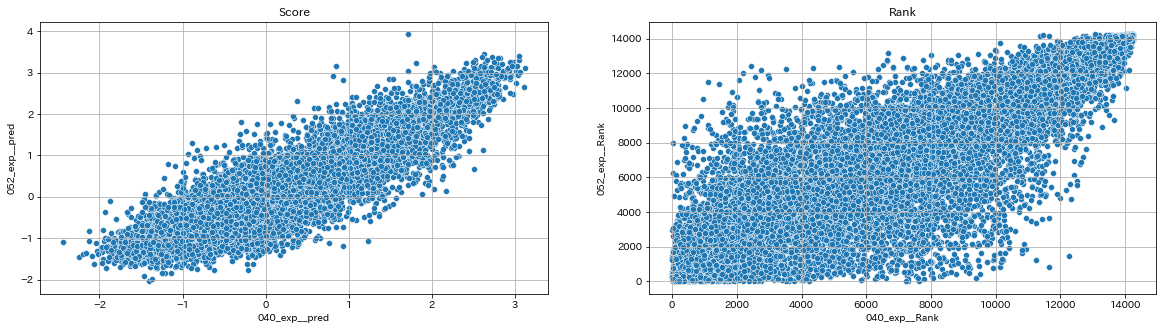

In [282]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(OOF_DF["040_exp__pred"], OOF_DF["052_exp__pred"])
plt.grid()
plt.title("Score")

plt.subplot(1, 2, 2)
sns.scatterplot(OOF_DF["040_exp__Rank"], OOF_DF["052_exp__Rank"])
plt.grid()
plt.title("Rank")

plt.show()

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Rank Distribution
</h1>
<br>

In [283]:
rank_cols = [col for col in OOF_DF.columns.tolist() if "__Rank" in col]
print(len(rank_cols))

6


In [284]:
RANK_DF = OOF_DF[["text"]+rank_cols].copy()

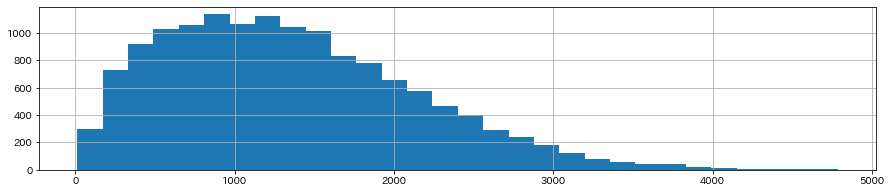

In [285]:
RANK_DF["std"] = RANK_DF[rank_cols].std(axis=1)
RANK_DF["mean"] = RANK_DF[rank_cols].mean(axis=1)

plt.figure(figsize=(15, 3))
plt.hist(RANK_DF["std"], bins=30)
plt.grid()
plt.show()

In [286]:
RANK_DF.sort_values("std", ascending=False).head(20)

,text,040_exp__Rank,041_exp__Rank,049_exp__Rank,052_exp__Rank,ohashi_040_exp__Rank,thajime_0206_exp__Rank,std,mean
6913,Copyright MXMXLI BY ASS_JH GY}},1184,663,1184,371,11477,8321,4788.211051,3866.666667
10383,Yes you did white boy!,11645,975,2682,831,6675,10020,4685.796183,5471.333333
1316,Message \n\nThai Hooker love ya long time.\n\...,9480,499,1490,903,1836,10860,4684.683597,4178.000000
8299,It is there darn it,10409,605,2206,2296,1985,10835,4612.316670,4722.666667
13040,F . U . C . K . \nY . O . U,10360,6928,8419,11812,985,14112,4570.365748,8769.333333
7011,Die in a fire. 76.122.79.82,1878,5887,1029,5694,2376,13309,4532.195910,5028.833333
13474,NAZI NAZI RACIST RASCISTARIACIAITIARACISTRACIS...,13712,13649,13310,14099,13002,2703,4445.731770,11745.833333
3062,"""\n\n Barnstar \n\n The Australian Asshole of...",393,9544,9308,8981,1172,9426,4416.910851,6470.666667
8233,Imbecile. Give me proof.,10126,1404,2329,1670,2309,10747,4412.845314,4764.166667
7486,"Hello I am Clue Bot, and I am a Niger Fukcing ...",11818,3282,3687,6953,4682,13573,4380.158479,7332.500000


In [287]:
RANK_DF.sort_values("052_exp__Rank").head(2)

,text,040_exp__Rank,041_exp__Rank,049_exp__Rank,052_exp__Rank,ohashi_040_exp__Rank,thajime_0206_exp__Rank,std,mean
8975,PLEASE STOP DELETING MY POSTS!!!,484,178,4,1,769,4042,1561.644518,913.000000
9246,STOP DELETING STUFF FROM OCEANS THREE AND A HA...,548,653,163,2,6019,1325,2284.436707,1451.666667


In [288]:
num = 8975
display(RANK_DF.loc[num, "text"])
display(RANK_DF.loc[num, rank_cols+["mean"]])

'PLEASE STOP DELETING MY POSTS!!!'

040_exp__Rank               484
041_exp__Rank               178
049_exp__Rank                 4
052_exp__Rank                 1
ohashi_040_exp__Rank        769
thajime_0206_exp__Rank     4042
mean                      913.0
Name: 8975, dtype: object

In [289]:
tmp_df = val_df[val_df["more_toxic"]==RANK_DF.loc[num, "text"]]
tmp_df = pd.concat(
    [
        tmp_df,
        val_df[val_df["less_toxic"]==RANK_DF.loc[num, "text"]]
    ],
    axis=0
)
tmp_df

,worker,less_toxic,more_toxic
28948,284,PLEASE STOP DELETING MY POSTS!!!,A theory proposed by User Ophois on the James ...
28949,4,PLEASE STOP DELETING MY POSTS!!!,A theory proposed by User Ophois on the James ...
28950,293,PLEASE STOP DELETING MY POSTS!!!,A theory proposed by User Ophois on the James ...


In [290]:
val_df.loc[28948, "more_toxic"]

'A theory proposed by User Ophois on the James Walker talk page that I agree with is that he had the ability that Sylar now uses to make quick escapes, so Sylar had to freeze him in order to be able to kill him. ( )'

In [291]:
tmp_df = val_df[val_df["more_toxic"]==val_df.loc[28948, "more_toxic"]]
tmp_df = pd.concat(
    [
        tmp_df,
        val_df[val_df["less_toxic"]==val_df.loc[28948, "more_toxic"]]
    ],
    axis=0
)
tmp_df

,worker,less_toxic,more_toxic
28948,284,PLEASE STOP DELETING MY POSTS!!!,A theory proposed by User Ophois on the James ...
28949,4,PLEASE STOP DELETING MY POSTS!!!,A theory proposed by User Ophois on the James ...
28950,293,PLEASE STOP DELETING MY POSTS!!!,A theory proposed by User Ophois on the James ...


<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Each Ensemble
</h1>
<br>

In [343]:
eval_df = val_df.copy()
rank_df = val_df.copy()

In [347]:
# exp_list = ["038_exp", "040_exp", "ohashi_040_exp"]
exp_list = [
#     "038_exp",
    "040_exp", 
    "041_exp", 
#     "047_exp",
#     "048_exp",
    "049_exp",
#     "051_exp",
    "052_exp",
#     "053_exp",

#     "035_exp_DeBERTa_Base__Jigsaw_Unbiased",
#     "035_exp_HATE_BERT__Jigsaw_classification",
#     "035_exp_HATE_BERT__Jigsaw_Unbiased",
#     "035_exp_Luke_Base__Wiki_Attack",
#     "035_exp_RoBERTa_Base__Jigsaw_Unbiased",
#     "035_exp_TFIDF_Ridge__Jigsaw_classification",
#     "035_exp_TFIDF_Ridge__Ruddit",
]

ohashi_list = ["ohashi_040_exp"]
thajime_list = ["thajime_0206_exp"]

# exp_list += ohashi_list
# exp_list += thajime_list

In [348]:
OOF_DF = pd.DataFrame()
OOF_DF["text"] = text_df["text"]

for exp in tqdm(exp_list, total=len(exp_list)):
    
    oof = pd.read_pickle(f"../data/interim/{exp}/{exp}__text_df.pkl")
    oof.columns = ["text", f"{exp}__pred"]
    sc = StandardScaler()
    oof[f"{exp}__pred"] = sc.fit_transform(oof[f"{exp}__pred"].values.reshape(-1, 1))[:, 0] 
    
    OOF_DF = pd.merge(
        OOF_DF,
        oof,
        on="text",
        how="left"
    )
    OOF_DF[f"{exp}__Rank__pred"] = rankdata(OOF_DF[f"{exp}__pred"], method="ordinal")

  0%|          | 0/4 [00:00<?, ?it/s]

In [349]:
## Mean Average
pred_cols = [col for col in OOF_DF.columns.tolist() if "exp__pred" in col]
rank_cols = [col for col in OOF_DF.columns.tolist() if "exp__Rank__pred" in col]

OOF_DF["mean_pred"] = OOF_DF[pred_cols].mean(axis=1)
OOF_DF["mean_rank"] = OOF_DF[rank_cols].mean(axis=1)

display(OOF_DF.head())

,text,040_exp__pred,040_exp__Rank__pred,041_exp__pred,041_exp__Rank__pred,049_exp__pred,049_exp__Rank__pred,052_exp__pred,052_exp__Rank__pred,mean_pred,mean_rank
0,\n\nThe comment directly above this one are fr...,-0.354471,6288,-0.274179,6241,-0.049904,8325,-0.288842,6780,-0.241849,6908.50
1,\n\nwhy should people have to read crap posted...,0.263590,9742,0.736330,11470,0.803563,11492,1.030180,12008,0.708416,11178.00
2,\nGo F yourself you cottonheadednittymuggins.,2.230693,13742,0.820761,11703,0.704832,11219,0.759504,11417,1.128947,12020.25
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",-0.703533,3597,-0.484455,4867,-0.700648,3859,-0.726992,3614,-0.653907,3984.25
4,\n\n koreans claim \n\ni see youve seen the ...,-0.025503,8422,0.113479,8820,-0.187006,7543,-0.098659,8059,-0.049422,8211.00


In [350]:
OHASHI_DF = pd.DataFrame()
OHASHI_DF["text"] = text_df["text"]

for exp in tqdm(ohashi_list, total=len(ohashi_list)):
    
    oof = pd.read_pickle(f"../data/interim/{exp}/{exp}__text_df.pkl")
    oof.columns = ["text", f"{exp}__pred"]
    sc = StandardScaler()
    oof[f"{exp}__pred"] = sc.fit_transform(oof[f"{exp}__pred"].values.reshape(-1, 1))[:, 0] 
    
    OHASHI_DF = pd.merge(
        OHASHI_DF,
        oof,
        on="text",
        how="left"
    )
    OHASHI_DF[f"{exp}__Rank__pred"] = rankdata(OHASHI_DF[f"{exp}__pred"], method="ordinal")

  0%|          | 0/1 [00:00<?, ?it/s]

In [351]:
## Mean Average
pred_cols = [col for col in OHASHI_DF.columns.tolist() if "exp__pred" in col]
rank_cols = [col for col in OHASHI_DF.columns.tolist() if "exp__Rank__pred" in col]

OHASHI_DF["ohashi_mean_pred"] = OHASHI_DF[pred_cols].mean(axis=1)
OHASHI_DF["ohashi_mean_rank"] = OHASHI_DF[rank_cols].mean(axis=1)

display(OHASHI_DF.head())

,text,ohashi_040_exp__pred,ohashi_040_exp__Rank__pred,ohashi_mean_pred,ohashi_mean_rank
0,\n\nThe comment directly above this one are fr...,-0.494940,5277,-0.494940,5277.0
1,\n\nwhy should people have to read crap posted...,0.521151,10599,0.521151,10599.0
2,\nGo F yourself you cottonheadednittymuggins.,0.966582,11784,0.966582,11784.0
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",0.052639,8856,0.052639,8856.0
4,\n\n koreans claim \n\ni see youve seen the ...,-0.255057,7167,-0.255057,7167.0


In [352]:
TAMURA_DF = pd.DataFrame()
TAMURA_DF["text"] = text_df["text"]

for exp in tqdm(thajime_list, total=len(thajime_list)):
    
    oof = pd.read_pickle(f"../data/interim/{exp}/{exp}__text_df.pkl")
    oof.columns = ["text", f"{exp}__pred"]
    sc = StandardScaler()
    oof[f"{exp}__pred"] = sc.fit_transform(oof[f"{exp}__pred"].values.reshape(-1, 1))[:, 0] 
    
    TAMURA_DF = pd.merge(
        TAMURA_DF,
        oof,
        on="text",
        how="left"
    )
    TAMURA_DF[f"{exp}__Rank__pred"] = rankdata(TAMURA_DF[f"{exp}__pred"], method="ordinal")

  0%|          | 0/1 [00:00<?, ?it/s]

In [353]:
## Mean Average
pred_cols = [col for col in TAMURA_DF.columns.tolist() if "exp__pred" in col]
rank_cols = [col for col in TAMURA_DF.columns.tolist() if "exp__Rank__pred" in col]

TAMURA_DF["thajime_mean_pred"] = TAMURA_DF[pred_cols].mean(axis=1)
TAMURA_DF["thajime__mean_rank"] = TAMURA_DF[rank_cols].mean(axis=1)

display(TAMURA_DF.head())

,text,thajime_0206_exp__pred,thajime_0206_exp__Rank__pred,thajime_mean_pred,thajime__mean_rank
0,\n\nThe comment directly above this one are fr...,-0.701147,2647,-0.701147,2647.0
1,\n\nwhy should people have to read crap posted...,1.422190,12944,1.422190,12944.0
2,\nGo F yourself you cottonheadednittymuggins.,-0.370746,6939,-0.370746,6939.0
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",-0.550089,4852,-0.550089,4852.0
4,\n\n koreans claim \n\ni see youve seen the ...,-0.186648,8508,-0.186648,8508.0


In [354]:
OOF_DF["each_mean_pred"] = (OHASHI_DF["ohashi_mean_pred"] + TAMURA_DF["thajime_mean_pred"]+ OOF_DF["mean_pred"])/3.
OOF_DF["each_mean_rank"] = (OHASHI_DF["ohashi_mean_rank"] + TAMURA_DF["thajime__mean_rank"]+ OOF_DF["mean_rank"])/3.

In [355]:
rank_df = pd.merge(
    rank_df,
    OOF_DF[["text", "each_mean_rank"]],
    left_on = "less_toxic",
    right_on = "text",
    how = "left"
)
rank_df = rank_df.rename(columns={
    f"each_mean_rank": f"less__mean__rank"
})
rank_df = rank_df.drop("text", axis=1)

rank_df = pd.merge(
    rank_df,
    OOF_DF[["text", "each_mean_rank"]],
    left_on = "more_toxic",
    right_on = "text",
    how = "left"
)
rank_df = rank_df.rename(columns={
    f"each_mean_rank": f"more__mean__rank"
})
rank_df = rank_df.drop("text", axis=1)

In [356]:

eval_df = pd.merge(
    eval_df,
    OOF_DF[["text", "each_mean_pred"]],
    left_on = "less_toxic",
    right_on = "text",
    how = "left"
)
eval_df = eval_df.rename(columns={
    f"each_mean_pred": f"less__mean__pred"
})
eval_df = eval_df.drop("text", axis=1)

eval_df = pd.merge(
    eval_df,
    OOF_DF[["text", "each_mean_pred"]],
    left_on = "more_toxic",
    right_on = "text",
    how = "left"
)
eval_df = eval_df.rename(columns={
    f"each_mean_pred": f"more__mean__pred"
})
eval_df = eval_df.drop("text", axis=1)

In [357]:
display(eval_df.head())
display(rank_df.head())

,worker,less_toxic,more_toxic,less__mean__pred,more__mean__pred
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,0.225803,-0.141768
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,-0.811337,-0.028779
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",-0.321059,-0.296229
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,0.478118,1.426139
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",0.195786,0.726181


,worker,less_toxic,more_toxic,less__mean__rank,more__mean__rank
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,9915.583333,7360.000000
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,2481.166667,8504.750000
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",6555.916667,6635.750000
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,10179.750000,12727.166667
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",9743.750000,11351.250000


In [358]:
eval_df[f"Diff__mean_pred"] = eval_df["more__mean__pred"] - eval_df["less__mean__pred"]
tmp_score = eval_df[eval_df[f"Diff__mean_pred"]>0][f"Diff__mean_pred"].count()/len(eval_df)
print(f"Mean Pred Score: {tmp_score:.6f}")

Mean Pred Score: 0.727149


In [359]:
rank_df[f"Diff__mean_rank"] = rank_df["more__mean__rank"] - rank_df["less__mean__rank"]
tmp_score = rank_df[rank_df[f"Diff__mean_rank"]>0][f"Diff__mean_rank"].count()/len(rank_df)
print(f"Mean Rank Score: {tmp_score:.6f}")

Mean Rank Score: 0.725455
